In [ ]:
%pip install ipympl

import sys
import os
import yaml


sys.path.insert(1, "/Volumes/EeroQ/lib/zeroheliumkit-dev/") 
import numpy as np
from math import pi

from shapely import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from shapely import affinity, intersects, line_merge, box, intersection
import shapely.affinity as aff
import copy

import matplotlib
import matplotlib.pyplot as plt
from zeroheliumkit import GeomCollection, SpiralInductor
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_DXF, Reader_GDS, Reader_Pickle


%matplotlib widget
%config InlineBackend.figure_format='retina'

from zeroheliumkit import Structure, Entity, Anchor, SuperStructure, GeomCollection, Taper, MultiAnchor, ArbitraryLine, Skeletone
from zeroheliumkit import Rectangle, Meander, MeanderHalf, Square, StraightLine, Circle, ArcLine
from zeroheliumkit.src.utils import midpoint, round_polygon
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_Pickle
from zeroheliumkit.helpers.resonator_calc import CPW_params
from zeroheliumkit.helpers.constants import speedoflight, mu_0, epsilon_0, hbar, alpha
import importlib
import tabulate

# sys.path.append('C:\\Users\\gageg\\source\\repos\\zeroheliumkit')



  

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gageg\QAnsys\qansys_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [134]:
# Unit definitions
GHz = 1e9
MHz = 1e6
kHz = 1e3

cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

# Load and validate parameters
with open('..\examples\params.yaml', 'r') as file:
    params = yaml.safe_load(file)

# Extract commonly used parameters
resonator_params = params['resonator']
geometry = resonator_params['geometry']

# Verify all required parameters exist
required_params = {
    'device': ['size', 'offset_from_edge'],
    'resonator': ['type', 'frequency', 'eps', 'substrate_h', 'geometry'],
    'resonator.geometry': ['w', 'g', 'coupling_length', 'openend_length', 
                          'distance_from_waveguide', 'radius', 'num']
}

def validate_params(params_dict, required):
    for section, fields in required.items():
        section_parts = section.split('.')
        current = params_dict
        for part in section_parts:
            if part not in current:
                raise KeyError(f"Missing section {part} in parameters")
            current = current[part]
        for field in fields:
            if field not in current:
                raise KeyError(f"Missing parameter {field} in section {section}")

validate_params(params, required_params)

# Create geometry parameters for convenience
g_params = geometry  # For backward compatibility
gp = {  # For legacy code support
    'w': params['feedline']['w'],
    'g': params['feedline']['g'],
    'coupling_length': geometry['coupling_length'],
    'openend_length': geometry['openend_length'],
    'distance_from_waveguide': geometry['distance_from_waveguide'],
    'radius': geometry['radius'],
    'num': geometry['num']
}

In [135]:
def calculate_sheet_inductance(
    width: float,
    length: float,
    thickness: float,
    resistivity: float,
    critical_temp: float,
    delta_0: float = 1.76,  # BCS gap parameter
) -> tuple[float, float]:
    """Calculate sheet inductance from film parameters"""
    # Calculate sheet resistance 
    R_square = resistivity / thickness
    
    # Calculate kinetic inductance using BCS relationship
    h_bar = 1.0545718e-34  # Reduced Planck constant
    delta = delta_0 * critical_temp * 1.380649e-23  # Gap energy in Joules
    L_kinetic = h_bar * R_square / (pi * delta)
    
    return R_square, L_kinetic

# Calculate sheet and kinetic inductance
R_sq, L_k = calculate_sheet_inductance(
    width=10*um,
    length=1000*um,
    thickness=10*nm,
    resistivity=5.5*um,
    critical_temp=10.84
)

# Initialize CPW parameters
cpw = CPW_params(
    eps_substrate=params["resonator"]["eps"],
    width=params["resonator"]["geometry"]["w"] * um,
    gap=params["resonator"]["geometry"]["g"] * um,
    height_substrate=params["resonator"]["substrate_h"] * um,
    sheet_inductance=L_k  # Add the kinetic inductance here
)

cpw.calculate_params()

In [136]:
# Configure appearance
plot_config = {
    "gnd": BLUE,
    "open": ORANGE, 
    "temp": RED,
    "island": YELLOW2,
    "anchors": GRAY,
    "other": GREEN
}

# Initialize structures
route_config = {}
chip = SuperStructure(route_config)

# Create pad structure
pad = Structure()
pad.add_layer("open", round_polygon(Square(200), 40))
pad.add_layer("temp", round_polygon(Square(190), 36))
pad.add_anchor(Anchor((0,0), -90, "o"))

# Create CPW launcher
cpwlauncher = Taper(
    length=200,
    layers={
        "temp": (geometry["w"] * um * 50, geometry["w"] * um * 4),
        "open": (geometry["w"] * um * 100, geometry["w"] * um * 8)
    },
    alabel=("a1", "a2")
)

cpwlauncher.cut_polygon("temp", Rectangle(50, 400, (-275, 0)))
cpwlauncher.get_anchor("a1").move(150)
cpwlauncher.remove_skeletone()

# Configure chip dimensions
Lx = params["device"]["size"][0]
Ly = params["device"]["size"][1]
spacing = 1000
offset = params["device"]["offset_from_edge"]

# Generate coordinate lists for pads
coords_t = [(-Lx/2 + offset, spacing/2, 0)] + \
          [(-spacing*5/2 + spacing*i, Ly/2 - offset, -90) for i in range(6)] + \
          [(Lx/2 - offset, spacing/2, 180)]

coords_d = [(Lx/2 - offset, -spacing/2, 180)] + \
          [(spacing*5/2 - spacing*i, -Ly/2 + offset, 90) for i in range(6)] + \
          [(-Lx/2 + offset, -spacing/2, 0)]

# Add anchors to chip
for i, coord in enumerate(coords_t + coords_d):
    x, y, angle = coord
    chip.add_anchor(Anchor((x,y), angle, f"p{i}"))

In [137]:
# Calculate resonator parameters
target_freq = 7.7 * GHz
resonator_type = resonator_params["type"]
harmonic = 0

# Calculate length factor based on resonator type
if resonator_type == 0.25:
    length_factor = 0.25 * (2*harmonic + 1)
elif resonator_type == 0.5:
    length_factor = 0.5 * (harmonic + 1)
else:
    raise Exception("Choose 1/4 or 1/2 resonator type")

# Calculate resonator length
cpw.length = length_factor * speedoflight / (target_freq * np.sqrt(cpw.eps_eff))
cpw.frequency = target_freq

# Store calculated parameters
parameters = {
    "f0, GHz": round(target_freq/GHz, 3),
    "length, mm": round(cpw.length/mm, 2),
    "width, um": round(cpw.width/um, 2),
    "gap, um": round(cpw.gap/um, 2),
    "eps": round(cpw.eps_substrate),
    "eps_eff": round(cpw.eps_eff, 2),
    "impedance, Ohm": round(cpw.Z, 2),
    "L, nH/m": round(cpw.L * 1e9, 3),
    "C, pF/m": round(cpw.C * 1e12, 3)
}

Total number of 1-inch chips that fit on the 4-inch wafer: 5


<Axes: >

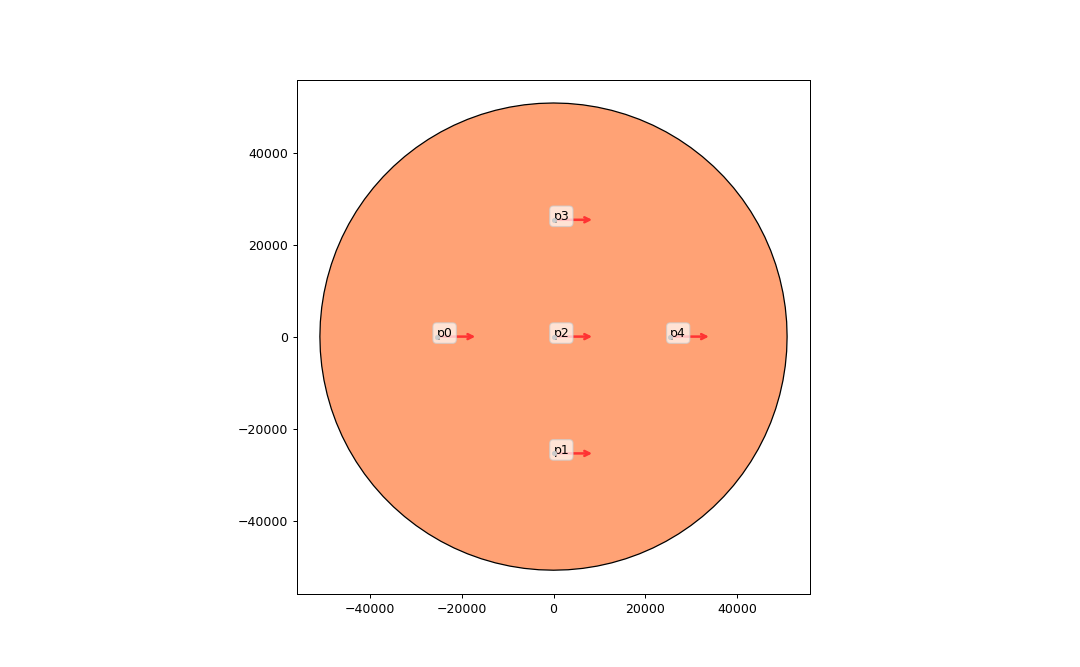

In [141]:
# Wafer layout parameters
inch = 25400
wafer_diameter = 101600  # 4-inch wafer
wafer_radius = wafer_diameter/2
edge_clearance = 0.5*cm
patch_size = inch

effective_radius = wafer_radius - edge_clearance

# Initialize wafer structure
wafer = SuperStructure(route_config)
wafer.add_layer("open", Circle(wafer_radius))

patch = Structure()
patch.add_layer("temp", Square(inch))

# Calculate chip placement
max_chips_across = int(2 * effective_radius / patch_size)
positions = []

# Generate a grid of positions
for i in range(-max_chips_across//2, max_chips_across//2 + 1):
    for j in range(-max_chips_across//2, max_chips_across//2 + 1):
        x = i * patch_size
        y = j * patch_size
        corners = [
            (x - patch_size/2, y - patch_size/2),
            (x + patch_size/2, y - patch_size/2),
            (x - patch_size/2, y + patch_size/2),
            (x + patch_size/2, y + patch_size/2)
        ]
        chip_fits = True
        for corner_x, corner_y in corners:
            distance_from_center = np.sqrt(corner_x**2 + corner_y**2)
            if distance_from_center > (wafer_radius - edge_clearance):
                chip_fits = False
                break
        if chip_fits:
            positions.append((x, y))

# Add anchors as structures
for i, pos in enumerate(positions):
    chip_pos = Structure()
    chip_pos.add_anchor(Anchor(pos, 0, f"p{i}"))
    wafer.append(chip_pos)

print(f"Total number of 1-inch chips that fit on the 4-inch wafer: {len(positions)}")
wafer.quickplot(plot_config)

In [142]:
# Display CPW parameters
print("\nCPW Parameters:")
print(f"Sheet inductance: {L_k:.2e} H/□")
print(f"Effective permittivity: {cpw.eps_eff:.2f}")
print(f"Impedance: {cpw.Z:.1f} Ω")

# Display resonator geometry
print("\nResonator Geometry:")
for key, value in parameters.items():
    print(f"{key}: {value}")


CPW Parameters:
Sheet inductance: 7.01e-11 H/□
Effective permittivity: 6.00
Impedance: 494.2 Ω

Resonator Geometry:
f0, GHz: 7.7
length, mm: 3.97
width, um: 1.8
gap, um: 1.0
eps: 11
eps_eff: 6.0
impedance, Ohm: 494.2
L, nH/m: 39353.877
C, pF/m: 161.133


In [143]:
# Visualize pad and launcher
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

pad.quickplot(plot_config, ax=ax1)
ax1.set_title("Pad Structure")

cpwlauncher.quickplot(plot_config, ax=ax2)
ax2.set_title("CPW Launcher")

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Display resonator paths
resonator.quickplot(plot_config)
plt.title("Resonator Design")
plt.axis('equal')
plt.grid(True)
plt.show()

In [ ]:
# Final chip layout
plt.figure(figsize=(12, 8))
chip.quickplot(plot_config)
plt.title("Complete Chip Layout")
plt.axis('equal')
plt.grid(True)
plt.show()

# Print final dimensions
print(f"\nChip Dimensions:")
print(f"Width: {Lx} μm")
print(f"Height: {Ly} μm")
print(f"Number of pads: {len(chip.anchors.labels)}")

In [ ]:
# Wafer layout visualization
plt.figure(figsize=(10, 10))
wafer.quickplot(plot_config)
plt.title("Wafer Layout with Chip Positions")
plt.axis('equal')
plt.grid(True)
plt.show()

# Print wafer statistics
print(f"\nWafer Statistics:")
print(f"Wafer diameter: {wafer_diameter/mm:.1f} mm")
print(f"Edge clearance: {edge_clearance/mm:.1f} mm")
print(f"Number of chips: {len(positions)}")